In [5]:
pip install xgboost --no-binary xgboost -v


Using pip 25.0.1 from /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pip (python 3.12)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split as sklearn_train_test_split

import os

%run diagnostics.ipynb


In [4]:
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df_original = pd.concat(chunks, ignore_index=True)
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
df = pd.merge(df_words, df_original, on = 'lexeme_id', how='inner')

In [5]:
df.head()
df.drop(columns=['learning_language', 'ui_language', 'lang_combination', 'timestamp', 'user_id',
                'gender', 'def', 'tense', 'POS', 'person', 'number', 'word', 'tags_list', 'SUBTLEX', 'h_recall',
                'lexeme_id', 'p_recall'], inplace=True)
df.drop(columns=['session_seen'], inplace=True)

In [6]:
print(len(df[df['session_correct']>1]), len(df[df['session_correct']<=1]))

4663977 7846024


In [235]:
# Expand df 

# df_expand = df.loc[df.index.repeat(df["session_seen"])].reset_index(drop=True)
# df_expand["outcome"] = np.concatenate([
#     np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
#     for s, c in zip(df["session_seen"], df["session_correct"])
# ])

# df_expand = df_expand.sample(n=15000000)

In [7]:
df = df[df['session_correct']<=1]

In [8]:
# columns transformation
df['memory_decay'] = df['history_correct'] / (1 + np.log1p(df['delta']))

# df['delta'] = np.sqrt(df['delta'])
# dff['delta'] = dff['delta']/(60*60*24) # convert time delta to days
# dff['avg_delta'] = np.sqrt(dff['avg_delta']/(60*60*24)) 
# dff['std_delta'] = np.sqrt(dff['std_delta']/(60*60*24)+1e-10)
# dff['history_wrong'] = np.log2(1+(dff['history_seen'] - dff['history_correct']))
# df['history_seen'] = np.log2((1+df['history_seen']))
# df['history_correct'] = np.log2(1+df['history_correct'])

In [9]:
df['history_wrong'] = df['history_seen']-df['history_correct']

In [10]:
def split_dataset(df):
    X = df.drop(columns='session_correct')
    y = df['session_correct']
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)

    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = split_dataset(df)

In [241]:
# Oversampling
# from imblearn.over_sampling import RandomOverSampler


# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [242]:
# from sklearn.model_selection import GridSearchCV

# parameters = {
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5],
#     'eta': [0.01, 0.1, 0.3],
# }
# clf = GridSearchCV(model, parameters, scoring='roc_auc', cv=3)
# clf.fit(X_train, y_train)

In [12]:
pos_class_weight = sum(y_train == 0) / sum(y_train == 1)


# Initialize XGBClassifier with scale_pos_weight and max_delta_step
model = XGBClassifier(
    n_estimators=100,
    objective='binary:logistic',
    scale_pos_weight=pos_class_weight,
    max_depth=7,
    max_delta_step=1,
    eta=0.2,
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Generate predictions
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)[:,1]



# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions, labels=[1, 0]))
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[853785 541372]
 [ 79565  94483]]

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.54      0.23    174048
           1       0.91      0.61      0.73   1395157

    accuracy                           0.60   1569205
   macro avg       0.53      0.58      0.48   1569205
weighted avg       0.83      0.60      0.68   1569205



<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=7, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)>

In [244]:
df_results = X_test.copy()
df_results['session_correct'] = y_test
df_results['session_correct_pred'] = predictions
df_results['session_correct_proba'] = predictions_proba

In [245]:
df_results.sort_values(by=['history_seen'])

,word_len,delta,history_seen,history_correct,memory_decay,history_wrong,session_correct,session_correct_pred,session_correct_proba
12461794,7,219271,1,1,0.075199,0,1,1,0.521200
11783881,5,1212011,1,1,0.066632,0,1,0,0.479055
8492875,8,173567,1,1,0.076544,0,1,1,0.526481
12479259,7,260215,1,1,0.074243,0,1,1,0.525520
6651899,4,236,1,1,0.154606,0,1,1,0.604856
...,...,...,...,...,...,...,...,...,...
5302537,5,173525,410,292,22.351359,118,0,0,0.312341
3428492,2,940,410,352,44.858233,58,1,0,0.253040
3415967,2,757,410,336,44.032753,74,1,0,0.254489
10590494,7,303,410,196,29.179573,214,1,0,0.091762


In [246]:
# Lower the threshold

# df_results['session_correct_pred'] = np.where(df_results['session_correct_proba'] >= 0.4, 1,0)# Evaluate the model
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, df_results['session_correct_pred'], labels=[1, 0]))
# print("\nClassification Report:")
# print(classification_report(y_test, df_results['session_correct_pred']))

<Axes: >

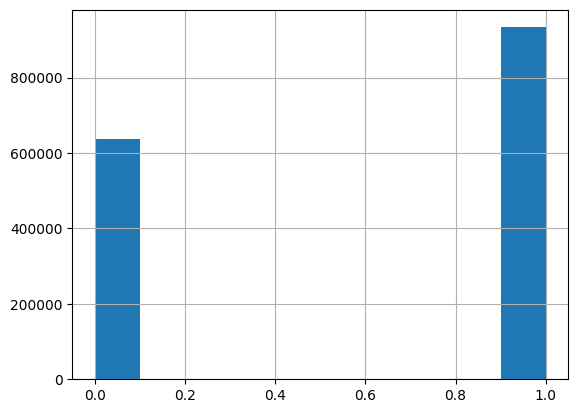

In [247]:
df_results['session_correct_pred'].hist()

<Axes: >

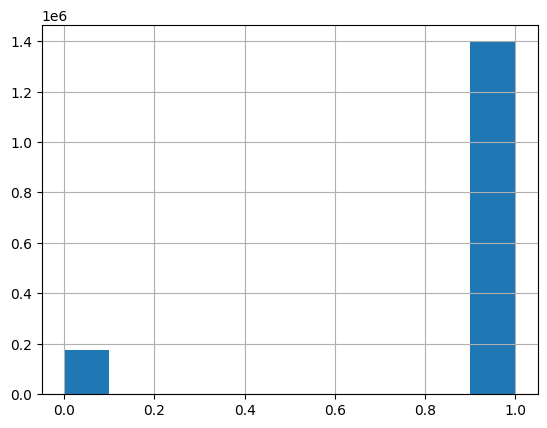

In [248]:
df_results['session_correct'].hist()

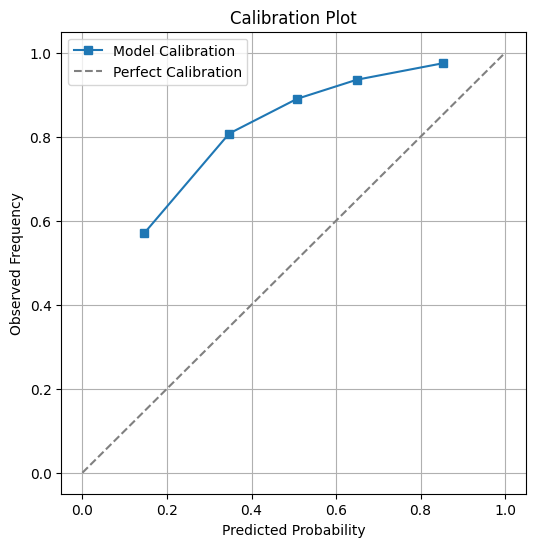

In [249]:
plot_calibration(df_results['session_correct'], df_results['session_correct_proba'], 'XGBoostBinary_calibration_plot.png')

AUC Score: 0.6132


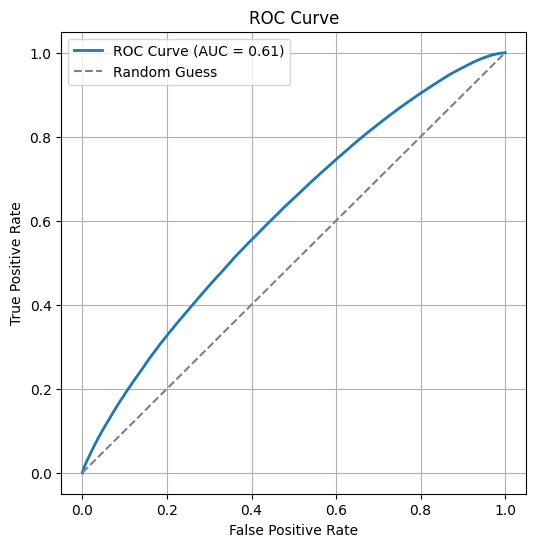

In [250]:
AUC_ROC(df_results['session_correct'], df_results['session_correct_proba'], 'XGBoostBinary_AUCROC.png')

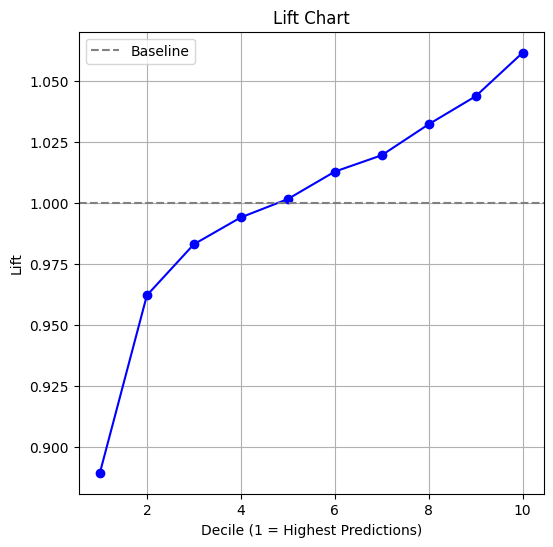

In [251]:
plot_lift(df_results, 'session_correct',  df_results['session_correct_proba'], 'XGBoostBinary_lift_plot.png')

In [252]:
import joblib

In [253]:
# save the model to disk

joblib.dump(model, 'model.pkl')

['model.pkl']

In [2]:
model

NameError: name 'model' is not defined